In [2]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
import glob

In [3]:
#Auto formatting for the fit label
def get_fit_label(pop, pcov, fit_label=""):
    string = ["" for _ in range(len(pop))]
    for i in range(len(pop)):
        string[i] = str(fit_label[i]) + ' = ' + str(round(pop[i],2)) + ' ± ' + str(round(np.sqrt(pcov[i][i]),2))
    label = ""
    for i in string:
        if i == string[len(string)-1]:
            label += str(i)
        else: label += str(i) + ', '
    return label
def get_curve_fit(curve_fit_function,bin_centers,count,param_guess):
    popt, pcov = curve_fit(curve_fit_function, bin_centers, count,p0=param_guess,)
    x_fit = np.linspace(min(bin_centers), max(bin_centers), 500)
    y_fit = curve_fit_function(x_fit, *popt)
    return [x_fit,y_fit,popt]

def plot_logscale(data,bins,label,title,xlabel,ylabel,bool_grid,bool_plot):
    plt.hist(data, bins=bins,label=label)
    #plotting
    plt.title(title)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(bool_grid): plt.show()
    return
def plot_twoHist(data, x_range, num_bin, 
              title="", xlabel="",ylabel="Number of Events", plot=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False,
              bool_log=True,bool_xlog=False, bool_grid=True, bool_error=False,
              data_label = "data",
              mc_data = False, mc_label = "MC",bool_scaleMC=True):
    count, bin_edges = np.histogram(data, bins=np.arange(x_range[0],x_range[-1],num_bin))
    countMC, blah= np.histogram(mc_data,bin_edges)

    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]
    ErrCount1 = np.sqrt(count)
    ErrBin = (bin_centers[1]-bin_centers[0])/2  # horizontal error bars

    if(bool_scaleMC):
        # Scale MC to data
        scale = len(data) / len(mc_data)
        print("Scaling MC by: ",scale)
        countMC = countMC * scale

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    if(bool_error): plt.errorbar(bin_centers, count, yerr=ErrCount1, xerr=ErrBin,
             ls='', marker='o', mfc='black', ms=4, mec='black',
             ecolor='black', label=data_label)
    else: plt.bar(bin_centers, count,color ='blue', width = ErrBin*2, label=data_label)
    
    plt.bar(bin_centers, countMC,color ='blue', width = ErrBin*2, label=mc_label)
    
    if(plot): plt.xlabel(xlabel, fontsize=15)
    if(plot): plt.ylabel(ylabel, fontsize=15)
    if(bool_log): plt.yscale('log')
    if(bool_xlog): plt.xscale('log')
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.legend(loc="upper right", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.show()


def plot_hist(data, x_range, num_bin, 
              title="", xlabel="",ylabel="Number of Events", plot=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False,
              bool_log=True,bool_xlog=False, bool_grid=True, bool_error=False,
              data_label = "data",
              mc_data = False, mc_label = "MC", bool_scaleMC = True,
              bool_returnFit = False, style_color = 'blue'
              ):
    """
    Plots a histogram of the data with optional curve fitting.
    Parameters:
    - data: The data to be plotted.
    - x_range: The range of x values for the histogram.
    - num_bin: The number of bins for the histogram.
    - title: The title of the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - plot: Whether to show the plot (default is True).
    - curve_fit_function: The function to fit the histogram data (default is False).
    - curve_fit_label: The label for the curve fit (default is an empty string).
    - param_guess: Initial guess for the curve fit parameters (default is False).
    - bool_log: Whether to use a logarithmic scale for the y-axis (default is True).
    - bool_xlog: Whether to use a logarithmic scale for the x-axis (default is False).
    """

    #Creating bins and error bars
    if(bool_xlog):
        plot_logscale(data=data,bins=np.logspace(start=np.log10(x_range[0]),stop=np.log10(x_range[-1]), num=num_bin),
                      title=title,label=data_label,xlabel=xlabel,ylabel=ylabel,
                      bool_grid=bool_grid,bool_plot=plot
                      )
        return 
    else: count, bin_edges = np.histogram(data, bins=np.arange(x_range[0],x_range[-1],num_bin))
    
    if(type(mc_data) != bool):
        plot_twoHist(data,x_range,num_bin,
                     title,xlabel,ylabel,plot,
                     curve_fit_function,curve_fit_label,param_guess,
                     bool_log,bool_xlog,bool_grid,bool_error,
                     data_label,mc_data,mc_label,bool_scaleMC
                     )
        return
    
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]
    ErrCount1 = np.sqrt(count)
    ErrBin = (bin_centers[1]-bin_centers[0])/2  # horizontal error bars
    
    #Manages curve fitting to the data
    if(curve_fit_function):
        x_fit, y_fit,popt = get_curve_fit(curve_fit_function,bin_centers,count,param_guess)
        


    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    if(curve_fit_function): plt.plot(x_fit, y_fit, 'r--', label=f'Fit: {curve_fit_label} a={popt[0]:.2f}, b={popt[1]:.2f}, c={popt[2]:.2f}')
    if(bool_error): plt.errorbar(bin_centers, count, yerr=ErrCount1, xerr=ErrBin,
             ls='', marker='o', mfc='black', ms=4, mec='black',
             ecolor='black', label=data_label)
    else: plt.bar(bin_centers, count,color =style_color, width = ErrBin*2, label=data_label)
    
    if(plot): plt.xlabel(xlabel, fontsize=15)
    if(plot): plt.ylabel(ylabel, fontsize=15)
    if(bool_log): plt.yscale('log')
    if(bool_xlog): plt.xscale('log')
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    #if(plot): plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.legend(loc="upper right", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.show()
    if(bool_returnFit): return popt

def plot_plot(datax, datay, xlim=False, ylim=False, 
              title="", xlabel="",ylabel="", 
              plot=True,bool_log_y=False, bool_log_x=False, bool_grid=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False, fit_label="", bool_returnFit = False
              ):
    
    # Plotting
    plt.title(title)
    plt.plot(datax, datay,'.',markersize=5,label='Data points')
    
    if(curve_fit_function):
        if(param_guess): popt, pcov = curve_fit(curve_fit_function, datax, datay,p0=param_guess)
        else: popt, pcov = curve_fit(curve_fit_function, datax, datay)
        # Plot fit
        x_fit = np.linspace(min(datax), max(datax), 500)
        y_fit = curve_fit_function(x_fit, *popt)
        
        plt.plot(x_fit, y_fit, 'r--', label=get_fit_label(popt, pcov, fit_label))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if(bool_log_y): plt.yscale('log')
    if(bool_log_x): plt.xscale('log')
    plt.legend()
    if(ylim): plt.ylim(ylim[0],ylim[-1])
    if(xlim): plt.xlim(xlim[0],xlim[-1])
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.show()
    if(bool_returnFit): return popt

def plot_hist2d(datax, datay, x_range=None, y_range=None, num_bin_x=10, num_bin_y=10,
                title="", xlabel="", ylabel="", plot=True,
                bool_grid=False
                ):
    range_xy = [x_range, y_range]
    if (x_range is None and y_range is None):
        range_xy = None
    
    plt.hist2d(datax,datay,bins=[num_bin_x,num_bin_y] ,range=range_xy, norm=colors.LogNorm())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.show() 

#Makes a scatter plot
def plot_scatter(datax, datay, xlim=False, ylim=False, 
                 title="", xlabel="",ylabel="Number of Events", 
                 plot=True, bool_grid=True
                 ):
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.scatter(datax,datay, color='blue', label='Data points')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend()
    if(ylim): plt.ylim(ylim[0],ylim[-1])
    if(xlim): plt.xlim(xlim[0],xlim[-1])
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.show()

#Makes a categorical bar chart
def plot_bar(pdgid_data, names, pdgids, title="",ylabel="Number of Events", plot=True):
    
    #Make sure everything is a np array
    pdgid_data = np.array(pdgid_data)
    names = np.array(names)
    pdgids = np.array(pdgids)

    # Count matched PDG IDs
    counts = np.array([np.sum(pdgid_data == pid) for pid in pdgids])

    # Find unmatched PDG IDs
    matched_ids = set(pdgids)
    unique_ids_in_data = set(np.unique(pdgid_data))
    unmatched_ids = sorted(unique_ids_in_data - matched_ids)

    if unmatched_ids:
        print("⚠️ Warning: The following PDG IDs were not matched to any bin:")
        print("   →", unmatched_ids)

    # Removes unmatched PDG IDs from names and counts
    mask = counts > 0
    names = names[mask]
    counts = counts[mask]
    if len(names) == 0:
        print("⚠️ Warning: No PDG IDs matched the data. No plot will be generated.")
        return

    # Plotting
    x = np.arange(len(names))
    plt.figure(figsize=(8, 5))
    plt.bar(x, counts, tick_label=names, color='blue', edgecolor='black')

    plt.xlabel("Particle Type")
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if(plot): plt.show()

def get_particle_count(data, title="mc_pdgID"):
    # Plot PDG ID
    particle_names = [
        'Photon', 'Electron', 'Muon', 'Tau',
        'Electron Neutrino', 'Muon Neutrino', 'Tau Neutrino',
        'Pion+', 'Pion-', 'Pion0',
        'Kaon+', 'Kaon-', 'Kaon0', 'Kaon0L', 'Kaon0S',
        'Neutron', 'Proton', 'Antiproton',
        'Deuteron', 'Triton', 'Alpha',
        'Lambda', 'Sigma+', 'Sigma0', 'Sigma-',
        'Xi0', 'Xi-', 'Omega-',
        'D+', 'D-', 'D0', 'D_s+', 'D_s-',
        'B+', 'B-', 'B0', 'B_s0', 'B_c+',
        'J/psi', 'Upsilon(1S)', 'Z boson', 'W+ boson', 'W- boson', 'Higgs boson', 'Gluon'
    ]

    particle_pdgs = [
        22,  # Photon
        11,  # Electron
        13,  # Muon
        15,  # Tau
        12,  # Electron neutrino
        14,  # Muon neutrino
        16,  # Tau neutrino
        211,  # Pi+
    -211,  # Pi-
        111,  # Pi0
        321,  # K+
    -321,  # K-
        311,  # K0
        130,  # K0L
        310,  # K0S
    2112,  # Neutron
    2212,  # Proton
    -2212,  # Antiproton
    1000010020, # Deuteron
    1000010030, # Triton
    1000020040, # Alpha particle (Helium-4 nucleus)
    3122,  # Lambda
    3222,  # Sigma+
    3212,  # Sigma0
    3112,  # Sigma-
    3322,  # Xi0
    3312,  # Xi-
    3334,  # Omega-
    411,   # D+
    -411,   # D-
    421,   # D0
    431,   # D_s+
    -431,   # D_s-
    521,   # B+
    -521,   # B-
    511,   # B0
    531,   # B_s0
    541,   # B_c+
    443,   # J/psi
    553,   # Upsilon(1S)
        23,  # Z boson
        24,  # W+ boson
        -24,  # W- boson
        25,  # Higgs boson
        21   # Gluon
    ]

    plot_bar(abs(data), particle_names, particle_pdgs,title)

def exponential(x, a, b,B):
    return a * np.exp(-x/b)+B

#Flattens two-dimenisional data
def flat(data, isMax=False,isLen=False,isSum = False):
    if(isMax): return np.array([np.max(i) if len(i)>0 else float('nan') for i in data])
    if(isLen): return np.array([len(i) for i in data])
    if(isSum): return sum_array(data)
    return np.array([i for sublist in data for i in sublist])

def sum_array(double_array, keepNegative = False):
    if(keepNegative):  return np.array([np.sum(i) for i in double_array])
    return np.array([np.sum(i) for i in double_array])
   
def get_mask(data, range, isDouble=False, makeDoubleMask=False):
    if(isDouble): return np.array( [any(range[0] <= i <= range[-1] for i in event)for event in data])
    return np.array( (data >= range[0]) & (data <= range[-1]) )

def get_RDF(pattern = "*.root", path_name = "/data/ahicks3/projects/eos/michelElectron/MC/", ttree_name = "output" ):
    chain = r.TChain()
    file_list = glob.glob(path_name+pattern)
    rdf = r.RDataFrame(ttree_name, file_list)
    return rdf

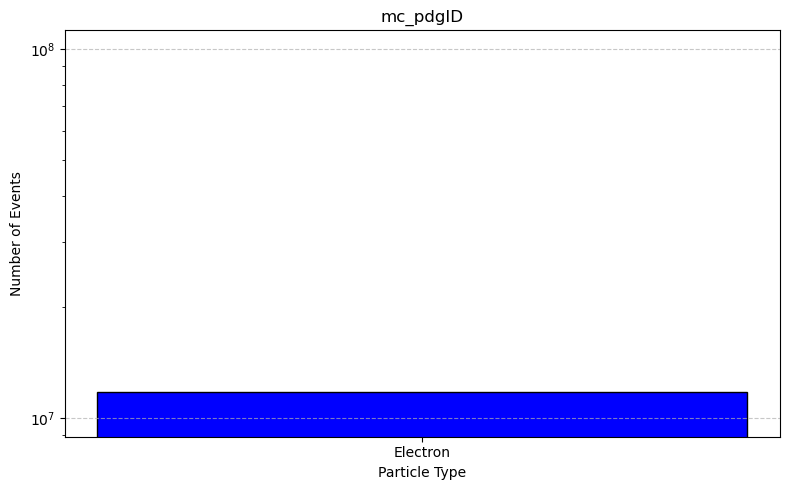

11761738


In [13]:
# Create RDataFrame from the events tree of the input file.
#mc_rdf = r.RDataFrame("output", "/data/ahicks3/projects/eos/michelElectron/MC/MC_Gen.root")
mc_rdf = get_RDF()

# Extract mc_branches
mc_nhits = mc_rdf.AsNumpy(columns=["digitNhits"])["digitNhits"]
mc_pdgID = mc_rdf.AsNumpy(columns=["mcpdg"])["mcpdg"]
mc_charge = np.array(mc_rdf.AsNumpy(columns=["digitCharge"])["digitCharge"])
mc_time = mc_rdf.AsNumpy(columns=["timeSinceLastTrigger_us"])["timeSinceLastTrigger_us"]

# Plot PDG ID
get_particle_count(abs(mc_pdgID))
print(len(mc_pdgID))

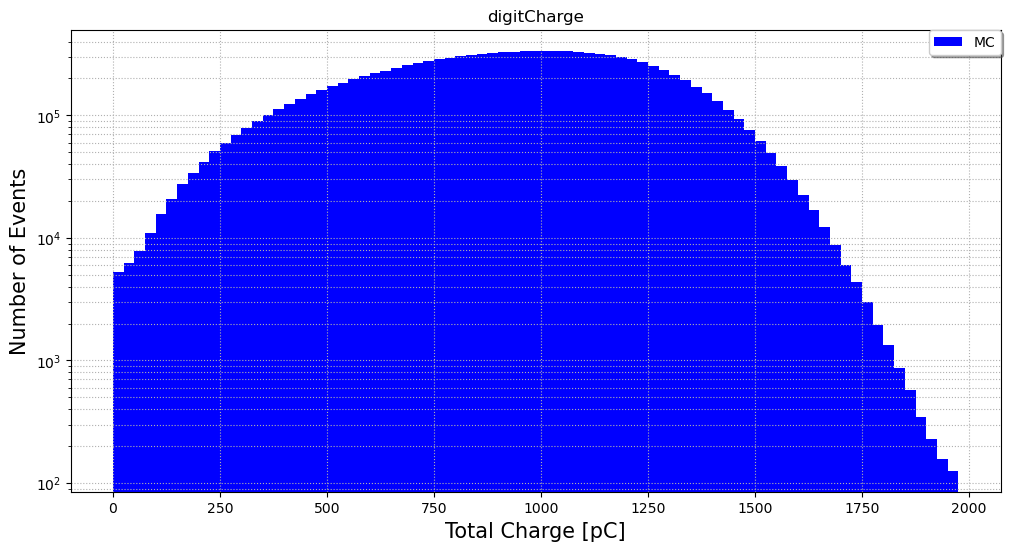

In [5]:
def guass(x,a,b,c):
    return a*np.exp(-( ((x-b)**2)/(c**2)))

plot_hist(flat( mc_charge,isSum=True),[0,2000],25,title="digitCharge",xlabel="Total Charge [pC]",data_label="MC")
#,curve_fit_function=guass,param_guess=[35,1000,10]

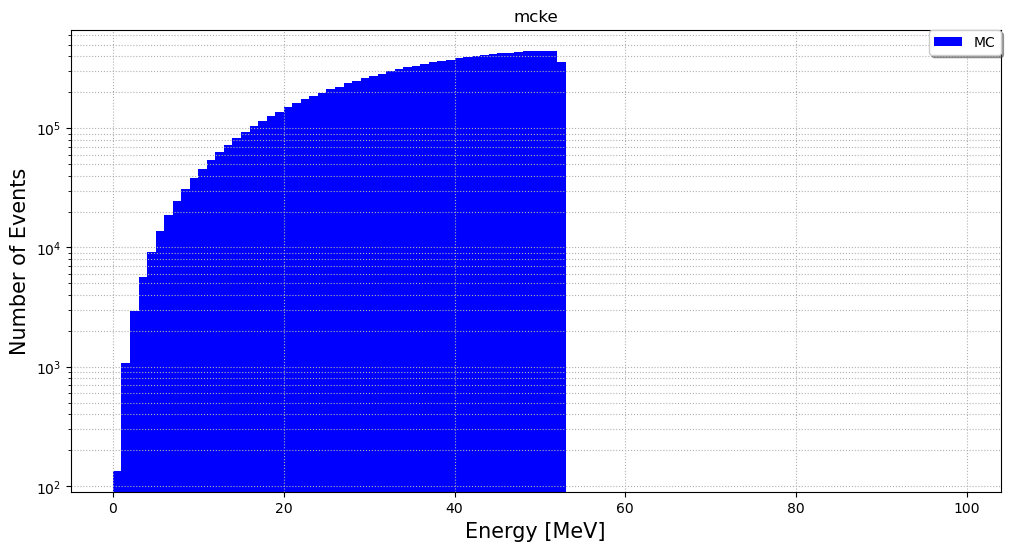

In [6]:
mc_energy = mc_rdf.AsNumpy(columns=["mcke"])["mcke"]

plot_hist(flat(mc_energy,isSum=True),[0,100],1,title="mcke",xlabel="Energy [MeV]",data_label="MC")

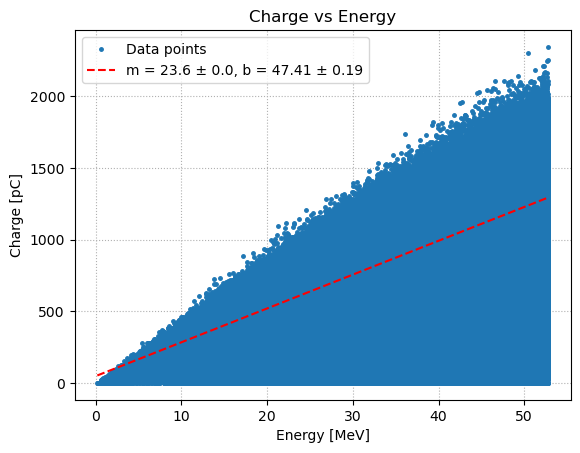

23.60206786928995 47.414784281850544


In [7]:
def linear(x, a, b):
    return (a * x) + b

m, b = plot_plot(flat( mc_energy,isSum=True),flat( mc_charge,isSum=True),
          title="Charge vs Energy",
          xlabel="Energy [MeV]",
          ylabel="Charge [pC]",
          curve_fit_function=linear,
          curve_fit_label="Linear Fit",
          param_guess=[25,0],
          fit_label=["m","b"], bool_returnFit=True)

print(m,b)

/data/ahicks3/anaconda3/envs/EOS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


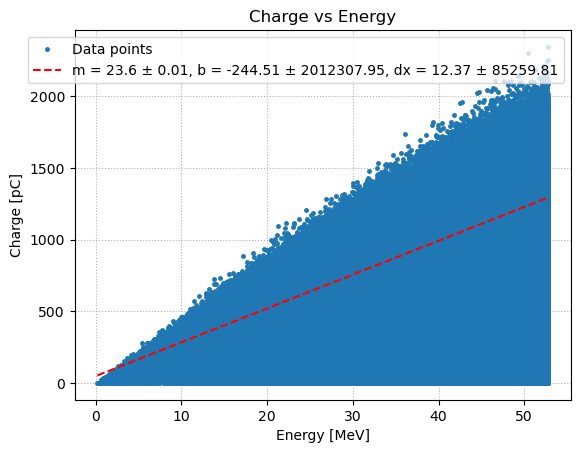

In [22]:
def linearMOD(x, m, b,dx):
    return (m * (x+dx)) + b

plot_plot(flat( mc_energy,isSum=True),flat( mc_charge,isSum=True),
          title="Charge vs Energy",
          xlabel="Energy [MeV]",
          ylabel="Charge [pC]",
          curve_fit_function=linearMOD,
          curve_fit_label="Linear Fit",
          param_guess=[25,0,0],
          fit_label=["m","b","dx"])

In [9]:
data_rdf = r.RDataFrame("output", "/data/eos/run3056/run3056_sum.root")

# Extract mc_branches
data_nhits = data_rdf.AsNumpy(columns=["digitNhits"])["digitNhits"]
data_charge = np.array(data_rdf.AsNumpy(columns=["digitCharge"])["digitCharge"])
data_time = data_rdf.AsNumpy(columns=["timeSinceLastTrigger_us"])["timeSinceLastTrigger_us"]


In [9]:
bool_time = get_mask(data_time, [0.5, 5])
bool_charge = get_mask(data_charge, [0, 2000],isDouble=True)
bool_mask = bool_time & bool_charge

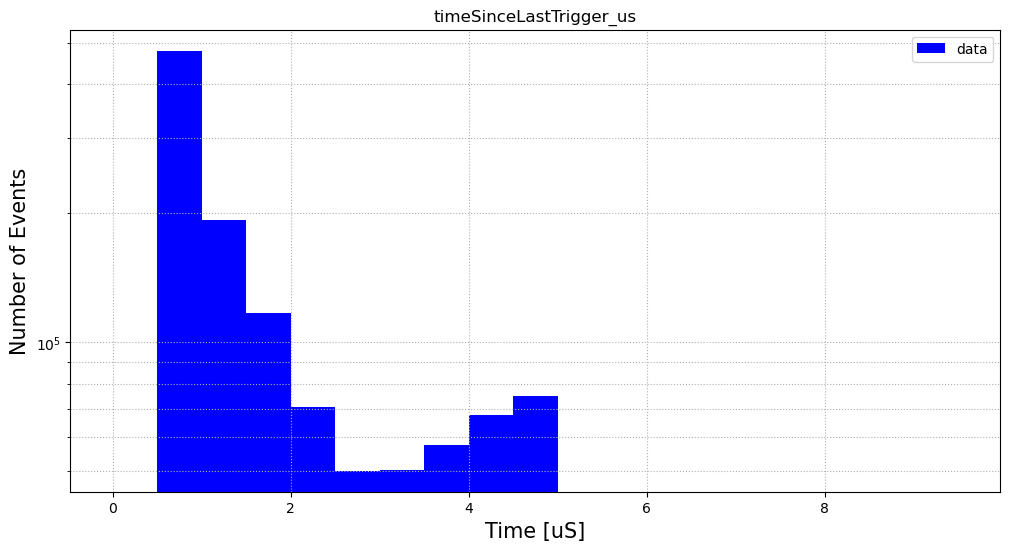

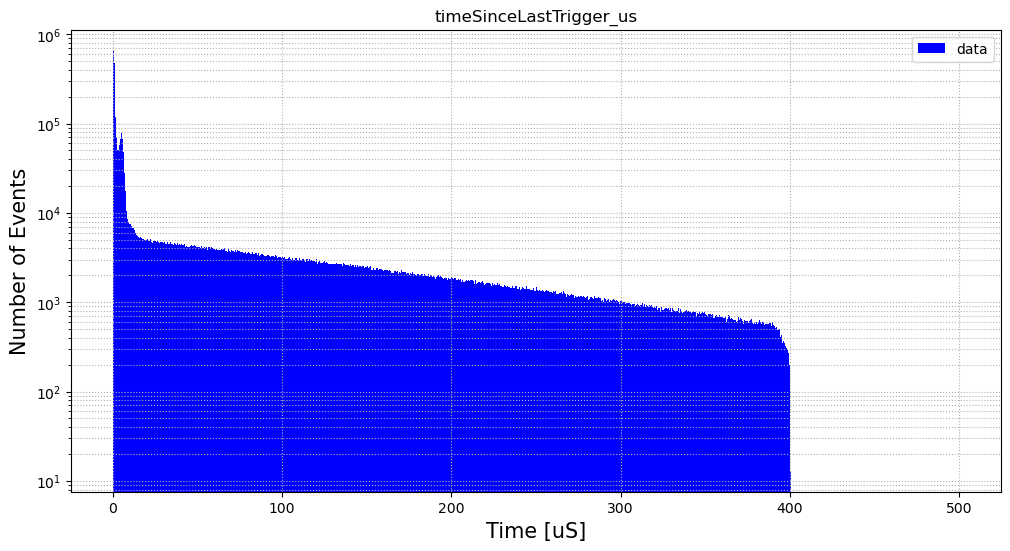

In [10]:
a = 24.49
b = 31.85
#data_energy = (flat(data_charge[bool_time],isSum=True)/a) - b
#plot_hist(data_energy,[0,200],2,title="mcke",xlabel="Total Energy [MeV]")


plot_hist(data_time[bool_mask],[0,10],0.5,title="timeSinceLastTrigger_us",xlabel="Time [uS]")
plot_hist(data_time,[0,500],0.5,title="timeSinceLastTrigger_us",xlabel="Time [uS]")


In [11]:
flat_charge_filter = flat(data_charge[bool_mask],isSum=True)
flat_charge = flat(data_charge,isSum=True)

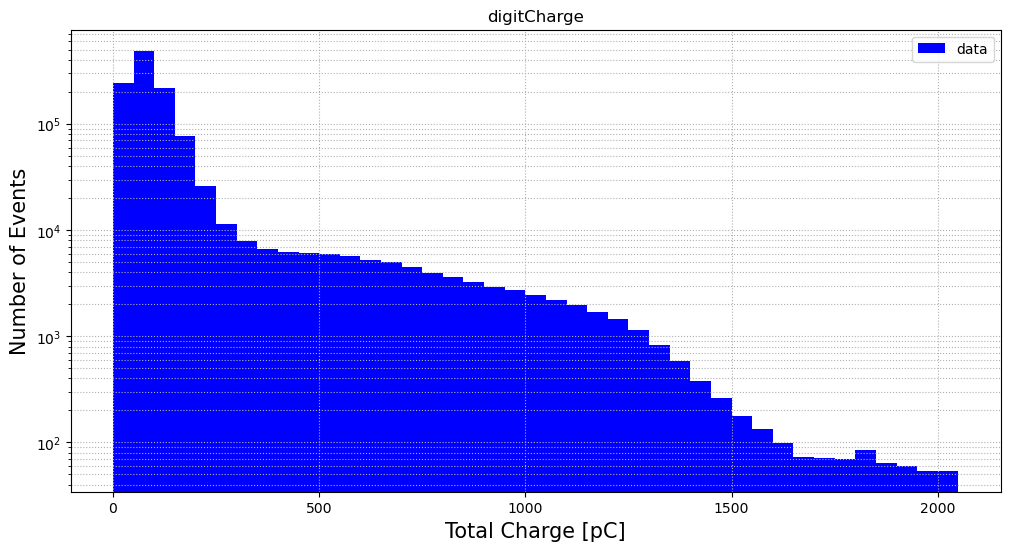

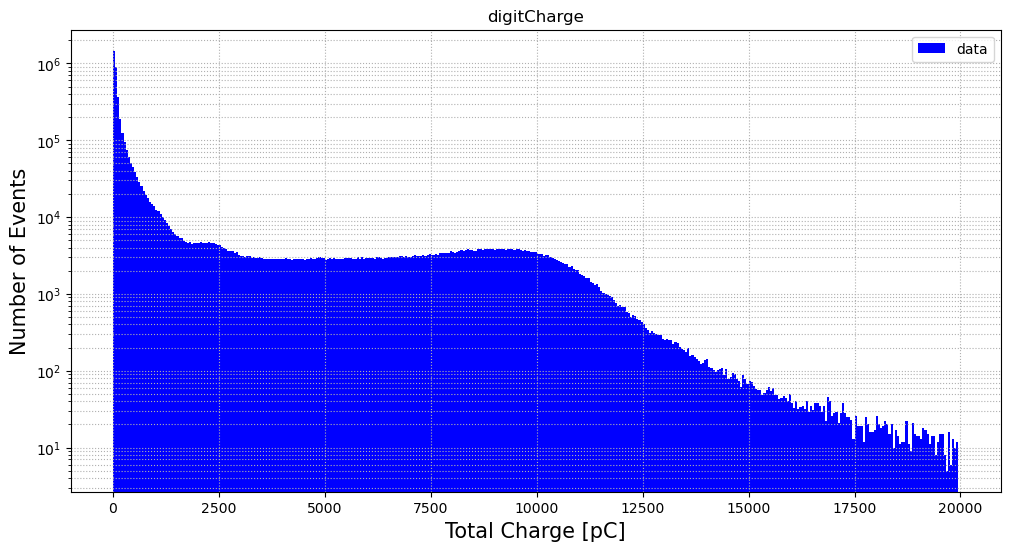

In [12]:
plot_hist(flat_charge_filter,[0,2100],50,title="digitCharge",xlabel="Total Charge [pC]")
plot_hist(flat_charge,[0,20000],50,title="digitCharge",xlabel="Total Charge [pC]")

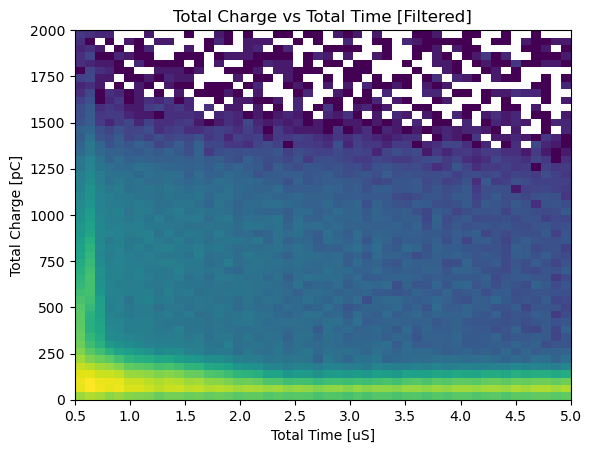

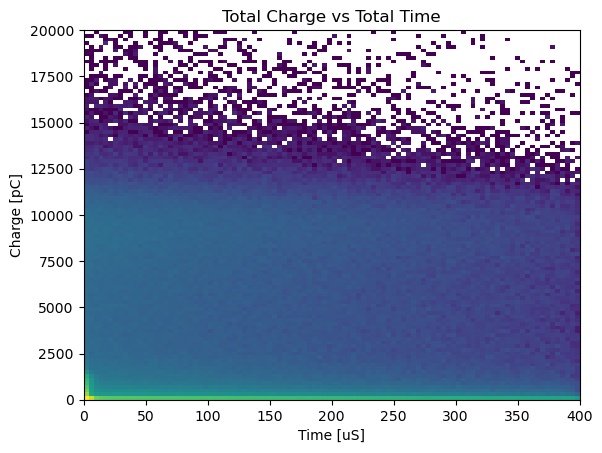

In [13]:
plot_hist2d(data_time[bool_mask],flat_charge_filter,x_range=[0.5,5],y_range=[0,2000],num_bin_x=50,num_bin_y=50,title="Total Charge vs Total Time [Filtered]",xlabel="Total Time [uS]",ylabel="Total Charge [pC]")
plot_hist2d(data_time,flat_charge,x_range=[0,400],y_range=[0,20000],num_bin_x=100,num_bin_y=100,title="Total Charge vs Total Time",xlabel="Time [uS]",ylabel="Charge [pC]")

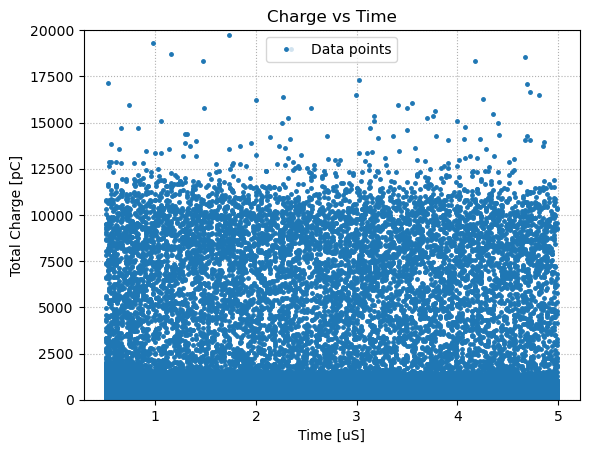

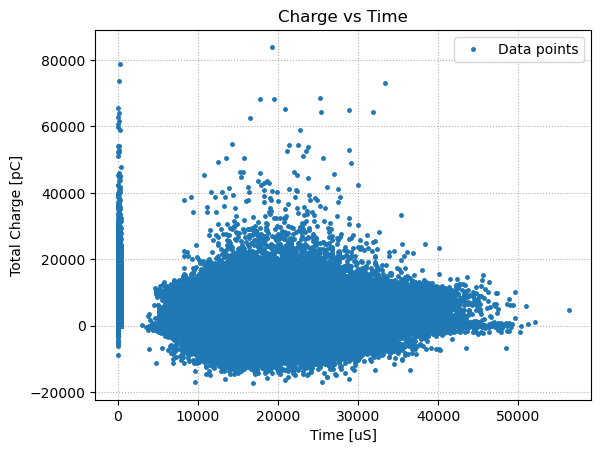

In [14]:
plot_plot(data_time[bool_mask],flat_charge_filter,
          title="Charge vs Time",
          xlabel="Time [uS]",
          ylabel="Total Charge [pC]",
          ylim=[00, 20000],
          )

plot_plot(data_time,flat_charge,
          title="Charge vs Time",
          xlabel="Time [uS]",
          ylabel="Total Charge [pC]",
          )


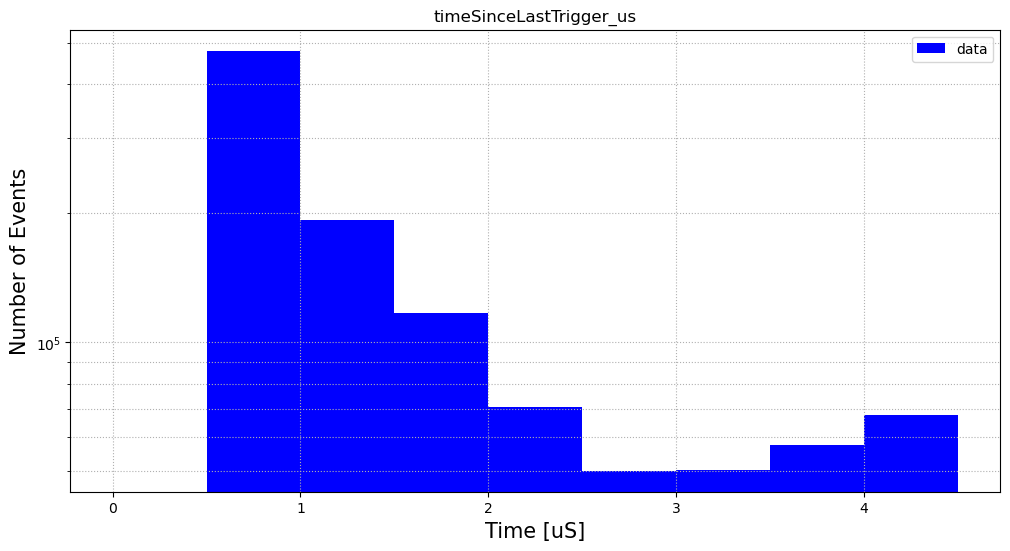

In [15]:
plot_hist(data_time[bool_mask],[0,5],0.5,title="timeSinceLastTrigger_us",xlabel="Time [uS]",bool_log=True)

In [17]:
data_timest = data_rdf.AsNumpy(columns=["timestamp"])["timestamp"]
data_timest = data_timest / 1e3 # Convert to microseconds

In [18]:
flat_charge = flat(data_charge,isSum=True)
bool_charge = get_mask(flat_charge, [0, 250])

In [19]:
time_diffc = np.diff(data_timest[bool_charge])
print(len(time_diffc)," =?= ", len(data_time))
print(len(flat_charge[bool_charge]))

3050309  =?=  5000576
3050310


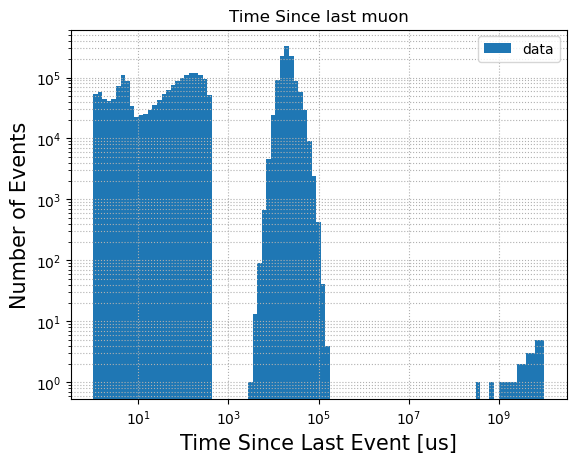

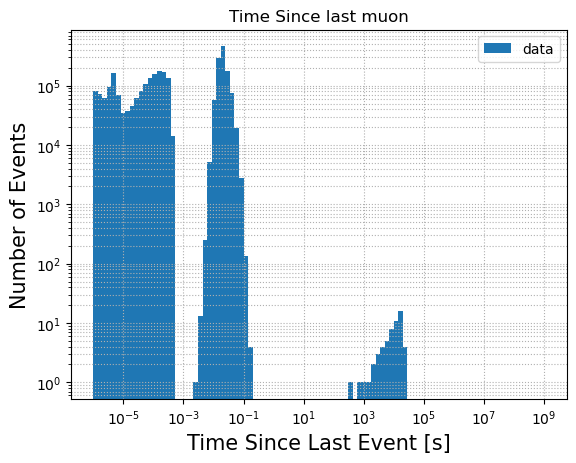

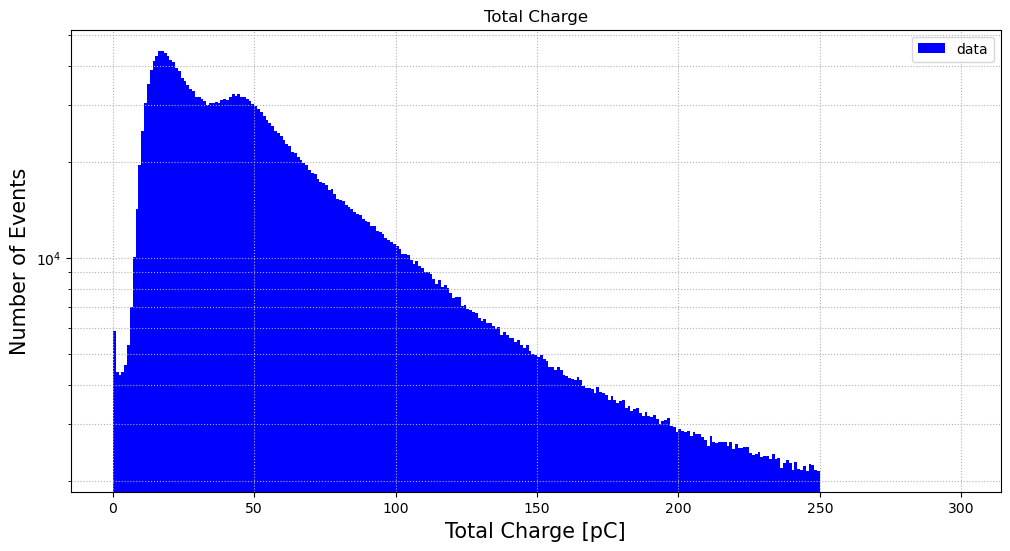

In [27]:
plot_hist(time_diffc,[10e-1,10e9],100,title="Time Since last muon",xlabel="Time Since Last Event [us]",bool_log=True, bool_xlog=True)
plot_hist(time_diffc/1e6,[10e-7,10e8],100,title="Time Since last muon",xlabel="Time Since Last Event [s]",bool_log=True, bool_xlog=True)
plot_hist((flat_charge[bool_charge]),[0,300],1,title="Total Charge",xlabel="Total Charge [pC]",bool_log=True)


In [28]:
f = r.TFile.Open("run496_all.root")
events = f.Get("output")
events.Show(0)

======> EVENT:0
 mcpdg           = -9999
 mcx             = -9999
 mcy             = -9999
 mcz             = -9999
 mcu             = -9999
 mcv             = -9999
 mcw             = -9999
 mcke            = 0
 mct             = -9999
 evid            = 0
 subev           = 0
 nhits           = 0
 triggerTime     = -55.6
 timestamp       = 14071143359939944
 timeSinceLastTrigger_us = 0
 mcid            = 0
 mcparticlecount = 0
 mcpecount       = 0
 mcnhits         = 0
 scintEdep       = 4.66911e-310
 scintEdepQuenched = 1.2732e-313
 scintPhotons    = 1.46325e+09
 remPhotons      = 5391
 cherPhotons     = 2
 hitPMTID        = (vector<int>*)0x55efcfff6ac0
 hitPMTTime      = (vector<double>*)0x55efd029c2f0
 hitPMTCharge    = (vector<double>*)0x55efc18aaad0
 digitNhits      = 76
 digitPMTID      = (vector<int>*)0x55efc189be60
 digitTime       = (vector<double>*)0x55efd02a5340
 digitCharge     = (vector<double>*)0x55efd02639a0
 digitNCrossings = (vector<int>*)0x55efd0229bb0
 digitPeak    

In [8]:
f = r.TFile.Open("/data/eos/run417.root")
events = f.Get("events")
events.Print()

******************************************************************************
*Tree    :events    : events                                                 *
*Entries :  4952309 : Total =     79352609869 bytes  File  Size = 23503392009 *
*        :          : Tree compression factor =   3.38                       *
******************************************************************************
*Br    0 :event_number : event_number/I                                      *
*Entries :  4952309 : Total  Size=   20314569 bytes  File Size  =    7559710 *
*Baskets :     5000 : Basket Size=      32000 bytes  Compression=   2.67     *
*............................................................................*
*Br    1 :nhit      : nhit/I                                                 *
*Entries :  4952309 : Total  Size=   20274537 bytes  File Size  =    7813845 *
*Baskets :     5000 : Basket Size=      32000 bytes  Compression=   2.58     *
*..................................................

In [8]:
run417_rdf = r.RDataFrame("events", "/data/eos/run417.root")

# Extract mc_branches
run417_charge = np.array(run417_rdf.AsNumpy(columns=["total_charge"])["total_charge"])
run417_time = run417_rdf.AsNumpy(columns=["deltat"])["deltat"]

In [9]:
bool_time = get_mask(run417_time, [0.5, 5])
run417_filter = run417_charge[bool_time]

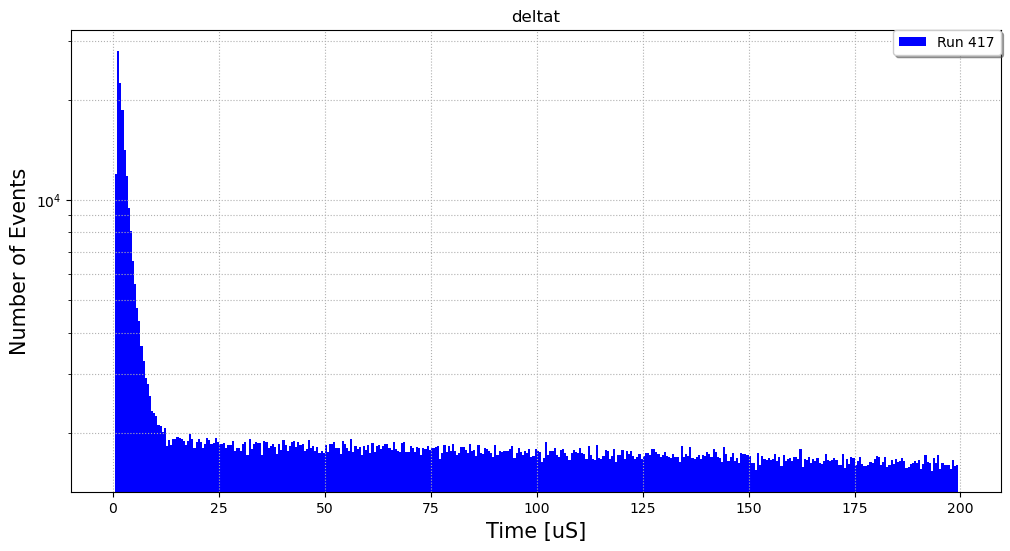

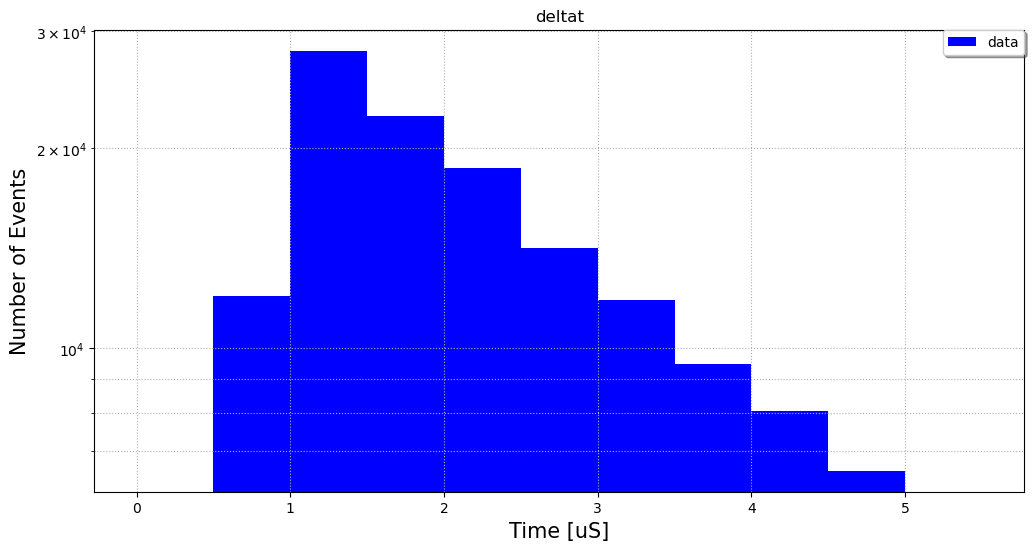

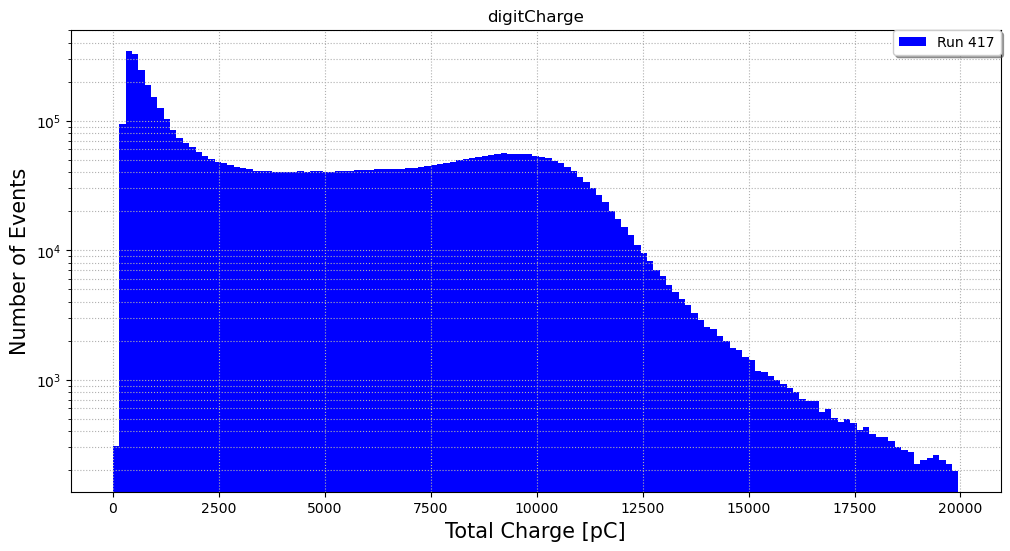

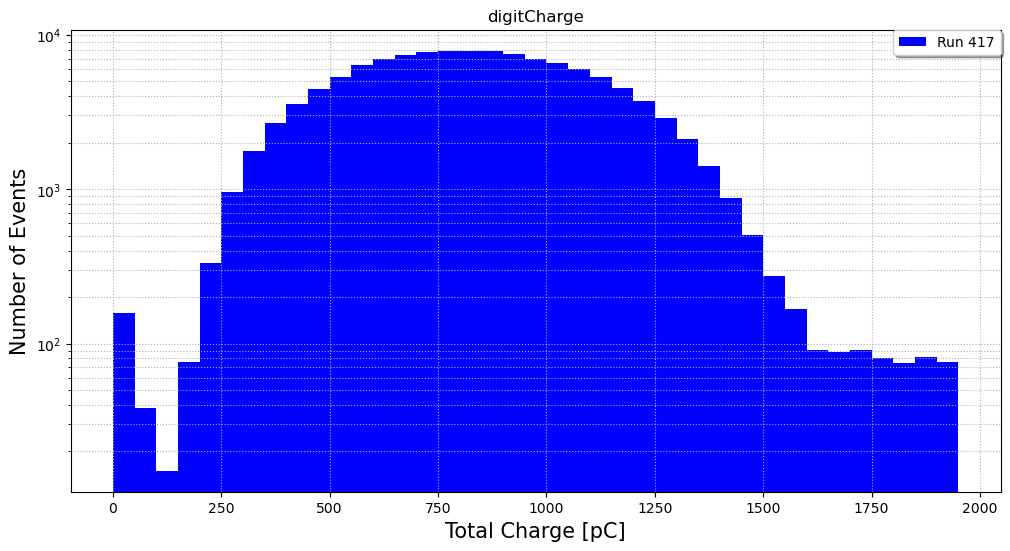

In [10]:
plot_hist(run417_time,[0,200],0.5,title="deltat",xlabel="Time [uS]",data_label="Run 417")
plot_hist(run417_time[bool_time],[0,6],0.5,title="deltat",xlabel="Time [uS]")
plot_hist(run417_charge,[0,20000],150,title="digitCharge",xlabel="Total Charge [pC]",data_label="Run 417")
plot_hist(run417_filter,[0,2000],50,title="digitCharge",xlabel="Total Charge [pC]",data_label="Run 417")

Scaling MC by:  0.011148607459203734


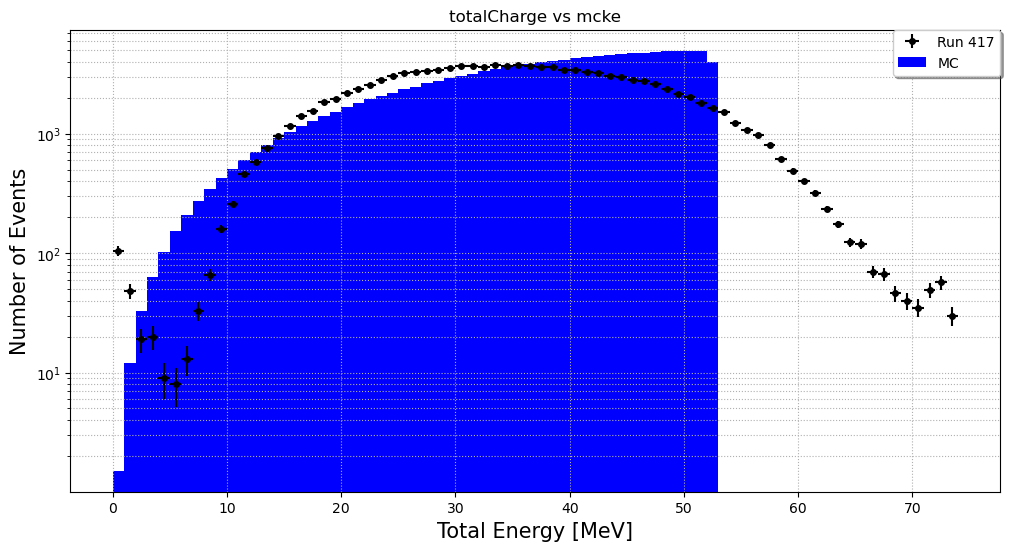

Scaling MC by:  0.011148607459203734


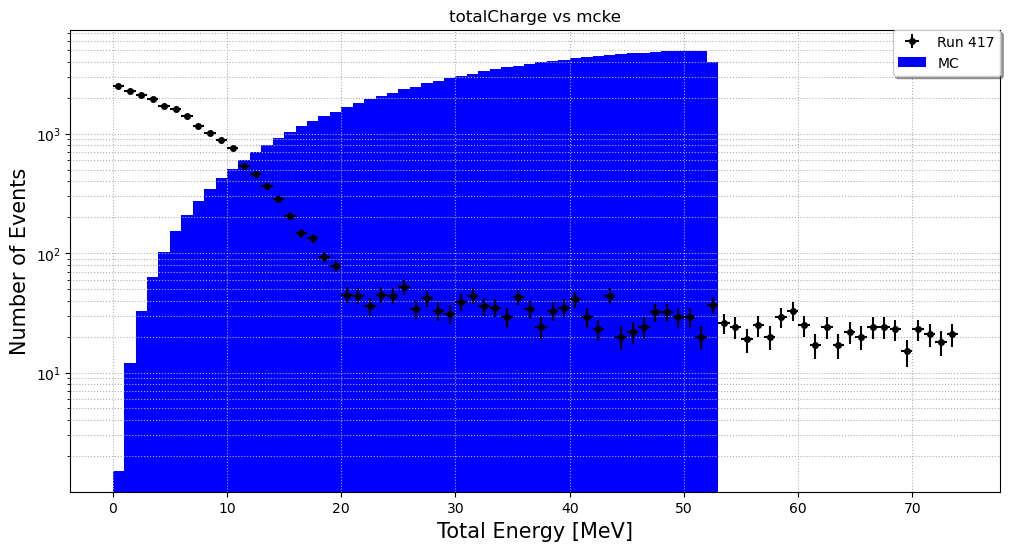

In [11]:
#a = 23.58
#a = 23.6
#b = 48.29
#b = 47.57
#data_energy = (flat(data_charge[bool_time],isSum=True)/a) - b

#Check channel ID, for dead channel. 
#eos -r 417?
#Scale down with lots of MC 

run417_energy = (run417_filter/m) - b*0

plot_hist(run417_energy,[0,75],1,title="totalCharge vs mcke",xlabel="Total Energy [MeV]",data_label="Run 417",mc_data=flat( mc_energy,isSum=True),mc_label="MC",bool_log=True,bool_error=True)
plot_hist(run417_energy-b,[0,75],1,title="totalCharge vs mcke",xlabel="Total Energy [MeV]",data_label="Run 417",mc_data=flat( mc_energy,isSum=True),mc_label="MC",bool_log=True,bool_error=True)

Scaling MC by:  0.011148607459203734


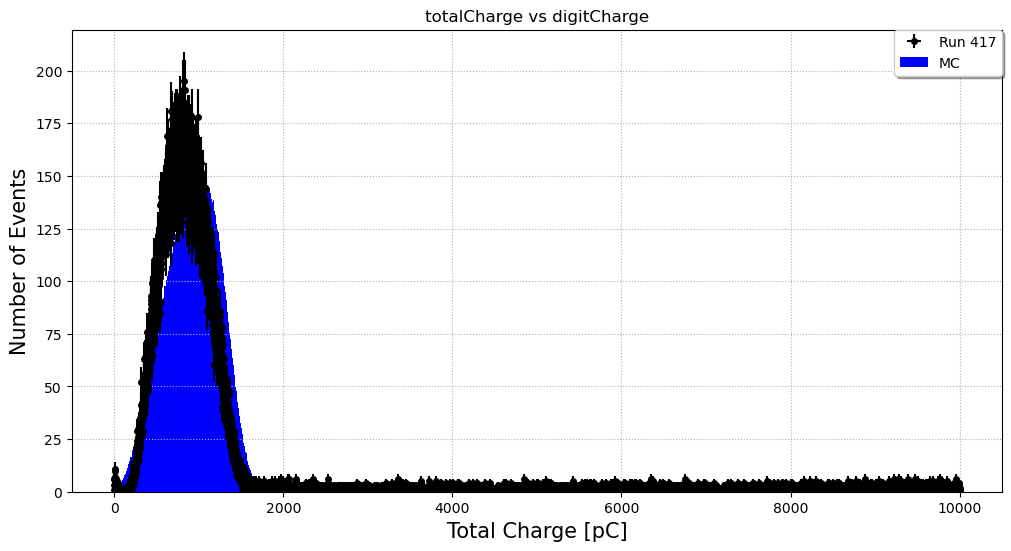

Scaling MC by:  0.011148607459203734


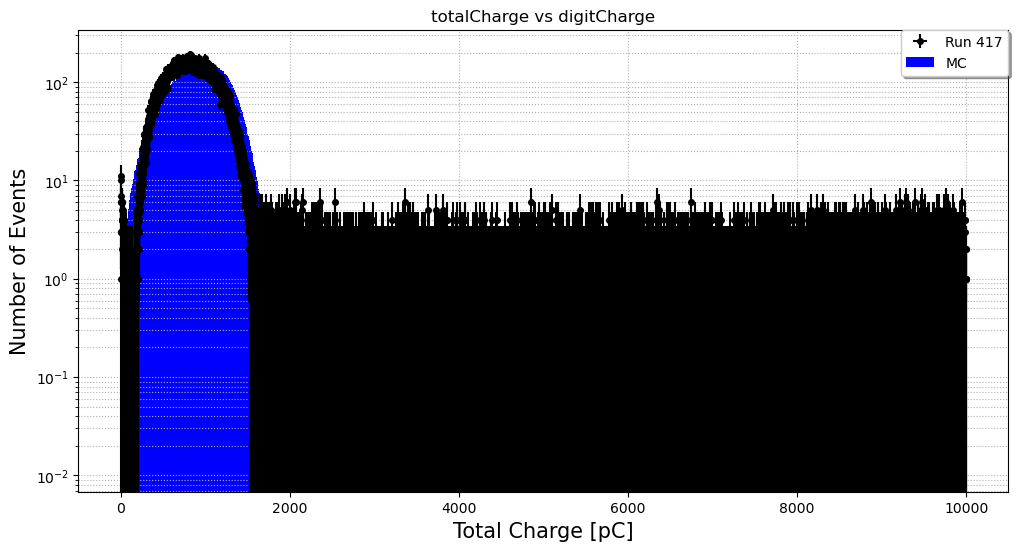

In [12]:
plot_hist(run417_filter,[0,10000],1,title="totalCharge vs digitCharge",xlabel="Total Charge [pC]",data_label="Run 417",mc_data=flat( mc_charge,isSum=True),mc_label="MC",bool_log=False,bool_error=True)
plot_hist(run417_filter,[0,10000],1,title="totalCharge vs digitCharge",xlabel="Total Charge [pC]",data_label="Run 417",mc_data=flat( mc_charge,isSum=True),mc_label="MC",bool_log=True,bool_error=True)